This workbook is a run through of univariate modeling using ARIMA and auto-select ARIMA.
This will cover manually setting the hyperparameters 
Where this workbook will stop, is after using seasonal and non-seasonal ARIMA modeling.



In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import matplotlib 
import scipy 
import sklearn

from statsmodels.tsa.api import (kpss, adfuller,seasonal_decompose, STL)
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
import statsmodels as sm
from pathlib import Path
import seaborn as sns
import statsmodels.api

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [12, 5] 


Some functions to use later

In [2]:
def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = 'Stationary'
        print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    return (s, results[0])

In [3]:
def split_data(data, test_split):
        l = len(data)
        t_idx = round(l*(1-test_split))
        train, test = data[ : t_idx], data[t_idx : ]
        print(f'train: {len(train)} , test: {len(test)}')
        return train, test

In [4]:
def combinator(items):
    combo = [i for i in product(*items)]
    return combo

In [5]:
#Dataset
life = pd.read_csv('/Users/paul.carroll/Github/Forecasting/data/USlifeexpenctancyBirth.csv',index_col = 'TIME')
life = life.iloc[0:,5:6]
rename_map = {'Value':'Expectancy'}
life.rename(columns=rename_map, inplace=True)
life.tail()

,Expectancy
TIME,
2016,76.2
2017,76.1
2018,76.2
2019,76.3
2020,74.2


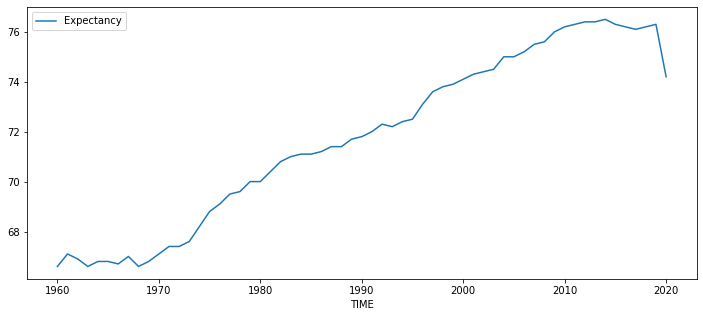

In [6]:
life.plot();
# Here there is a trend evident and the time series will require stationarity

In [7]:
test_split = 0.20

life_train, life_test = split_data(life, test_split)

train: 49 , test: 12


In [8]:
check_stationarity(life)
#series is non-stationary.

('Non-Stationary', 0.5267310005814907)

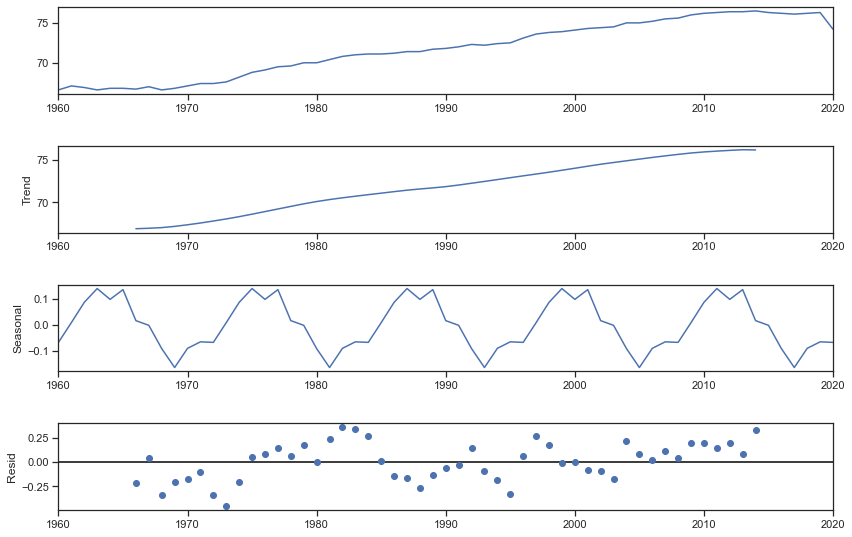

In [9]:
sns.set(style='ticks', rc={ "lines.linewidth":1.5})
decomposition = seasonal_decompose(life, period=12)
fig = decomposition.plot()
fig.set_size_inches(12,8)
plt.show();
# no seasonality, but a definite trend. 

There are three parts to the tuning of an ARIMA model, 4 to a SARIMAX. The parameters are (p,d,q).
The first stage with an ARIMA or SARIMAX model is to find the hyperparameter tunings, the p for AR, which is the auto-regressive part of the 'AR'IMA model. This value can be found from the PACF graph, which you run on the differenced univariate series of data. 
The d is the differencing order. The q is the MA part, the moving average which you obtain from the ACF graph. 
Below we will plot the ACF and PACF graphs to show you how to obtain these numbers.

In [10]:

#check stationarity of the life differenced dataset. Now this is < 0.05 can say data is now stationary.
life_diff = life.Expectancy.diff().dropna()
check_stationarity(life_diff)

'Stationary	 p-value:0.005698319652473299 	 lags:0


('Stationary', 0.005698319652473299)

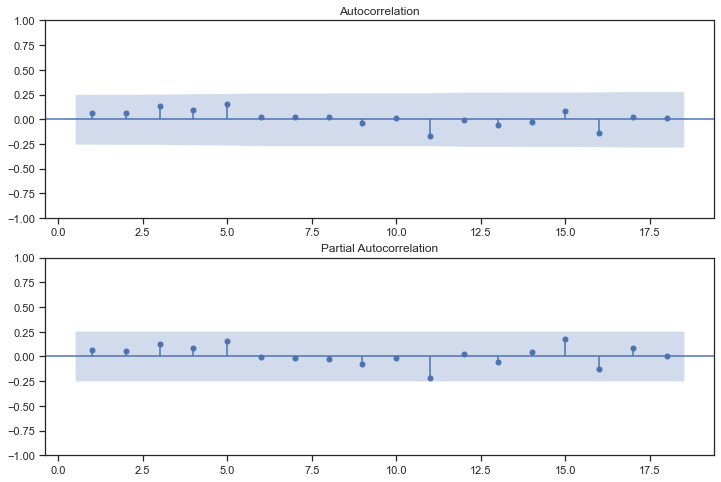

In [11]:
# As the life data does not show any obvious seasonality, trying to remove trend by differencing the data once.

fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(life_diff, zero=False, ax=ax[0])
plot_pacf(life_diff, zero=False, ax=ax[1])
plt.show() 

(1, 3)


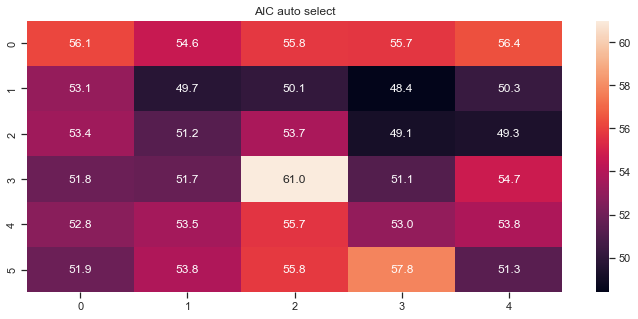

In [12]:
#and running it on the differenced set 

#Auto-select function to identify the p, and q for ARIMA.

auto_select = sm.tsa.stattools.arma_order_select_ic(life.Expectancy.diff(), max_ar=5, max_ma=4, ic='aic', trend='n', model_kw={}, fit_kw={})

print(auto_select.aic_min_order)

sns.heatmap(auto_select['aic'], annot=True, fmt='.1f')
plt.ylim([auto_select['aic'].shape[0], 0])
plt.title('AIC auto select')
plt.show()

In [13]:
# best p and q are 1 and 3. lowest score of 48.4

from statsmodels.tsa.arima.model import ARIMA
model1 = ARIMA(life['Expectancy'],order = (1,1,3)).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Expectancy   No. Observations:                   61
Model:                 ARIMA(1, 1, 3)   Log Likelihood                 -19.197
Date:                Tue, 13 Sep 2022   AIC                             48.393
Time:                        13:36:18   BIC                             58.865
Sample:                             0   HQIC                            52.490
                                 - 61                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8942      0.150      5.977      0.000       0.601       1.187
ma.L1         -0.9318      0.281     -3.313      0.001      -1.483      -0.381
ma.L2         -0.0840      0.413     -0.203      0.839      -0.893       0.725
ma.L3          0.4393      0.277      1.587      0.112      -0.103       0.982
sigma2         0.1077      0.021      5.132      0.000       0.067       0.149
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               658.88
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               2.78   Skew:                            -2.97
Prob(H) (two-sided):                  0.03   Kurtosis:                        18.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
life_tdiff = life_train.diff().dropna()


0 0 0.1467846875613826
0 1 0.14624419108070416
0 2 0.1475038250910923
0 3 0.14979040043943695
0 4 nan
1 0 0.14627453192164672
1 1 0.14698037213923532
1 2 0.14925723196125992
1 3 0.15000440313375948
1 4 nan
2 0 0.14815051859448133
2 1 0.14774878108870135
2 2 0.1524960222900464
2 3 0.16105968409033888
2 4 nan
3 0 0.14574389480943972
3 1 0.1457555580442185
3 2 0.16288629619554362
3 3 0.15527574013352777
3 4 nan
4 0 0.14595212118523093
4 1 0.14608674977774122
4 2 0.14712369350128687
4 3 0.14812357048841204
4 4 nan
(3, 0) 0.14574389480943972


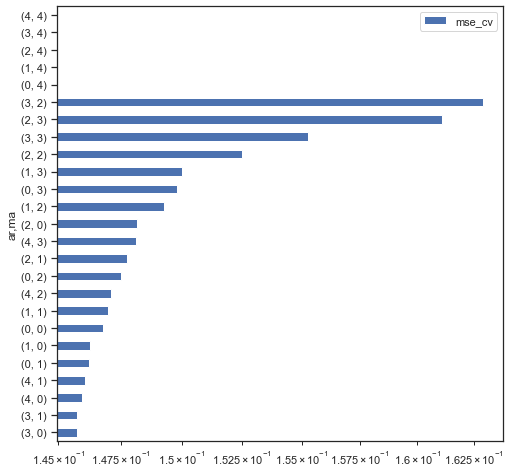

In [22]:
# Another way to check the best model output 
from sklearn.model_selection import TimeSeriesSplit

ts = TimeSeriesSplit(n_splits=3)
splits = [split for split in ts.split(life['Expectancy'].diff().values)]

best_order = (0, 0)
best_mse = 10**10
scores = []

for ar_order in range(5):
    for ma_order in range(5):
        try:
            mses = []
            for i in range(ts.n_splits):
                y_train = life['Expectancy'].diff().values[splits[i][0]]
                y_test = life['Expectancy'].diff().values[splits[i][1]]

                model_cv = ARIMA(y_train, order=(ar_order, 0, ma_order))
           
                result_cv = model_cv.fit()
                #start_params=np.zeros(model_cv.k_ar+model_cv.k_ma),
                 #              solver='lbfgs', method='css', trend='nc', ic='BIC')
                predictions_test = result_cv.predict(start=len(y_train), end=len(y_train)+len(y_test)-1)
                mses.append(((y_test - (predictions_test))**2).mean())
               
            mse_mean = np.mean(mses)
            scores.append((model_cv.k_ar, model_cv.k_ma, mse_mean))
            print(model_cv.k_ar, model_cv.k_ma, mse_mean)
            if mse_mean < best_mse:
                best_mse = mse_mean
                best_order = (model_cv.k_ar, model_cv.k_ma)

        except:
                scores.append((model_cv.k_ar, model_cv.k_ma, np.nan))
                print(model_cv.k_ar, model_cv.k_ma, np.nan)
               
print(best_order, best_mse)

df_r = pd.DataFrame(scores, columns=['ar', 'ma', 'mse_cv'])
df_r.groupby(['ar', 'ma'])[['mse_cv']].max().sort_values(by='mse_cv').plot(kind='barh', figsize=(8, 8))
plt.xscale('log')
plt.show()

In [38]:
# this parameter check suggests p = 3 and q = 0 for a best_mse fit
model2 = ARIMA(life['Expectancy'], order = (3,1,0)).fit()


In [24]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Expectancy   No. Observations:                   61
Model:                 ARIMA(3, 1, 0)   Log Likelihood                 -21.924
Date:                Tue, 13 Sep 2022   AIC                             51.848
Time:                        13:37:51   BIC                             60.225
Sample:                             0   HQIC                            55.125
                                 - 61                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1317      0.264      0.499      0.618      -0.386       0.649
ar.L2          0.1433      0.340      0.422      0.673      -0.523       0.810
ar.L3          0.3878      0.327      1.186      0.236      -0.253       1.029
sigma2         0.1202      0.009     13.286      0.000       0.102       0.138
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              1165.75
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               3.12   Skew:                            -3.60
Prob(H) (two-sided):                  0.01   Kurtosis:                        23.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

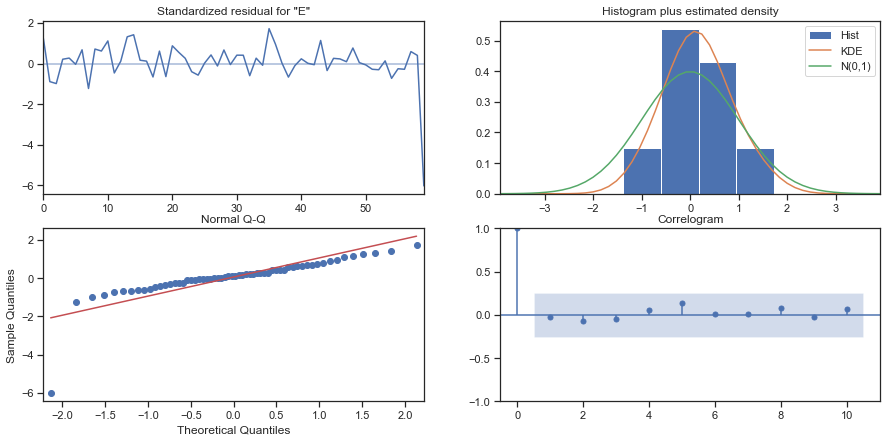

In [25]:
model.plot_diagnostics(figsize=(15,7));plt.show();

predicted=75.653001, expected=75.600000
predicted=75.750550, expected=76.000000
predicted=76.186921, expected=76.200000
predicted=76.372589, expected=76.300000
predicted=76.494681, expected=76.400000
predicted=76.574998, expected=76.400000
predicted=76.533083, expected=76.500000
predicted=76.609117, expected=76.300000
predicted=76.334496, expected=76.200000
predicted=76.202480, expected=76.100000
predicted=76.037862, expected=76.200000
predicted=76.154220, expected=76.300000
predicted=76.277659, expected=74.200000
Test RMSE: 0.595


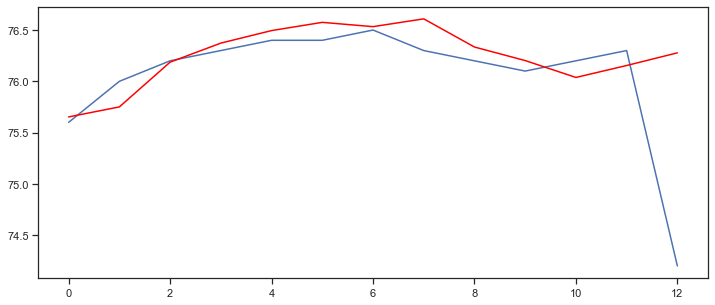

In [37]:
# forecasting forward. 

from sklearn.metrics import mean_squared_error
from math import sqrt
X = life['Expectancy'].values


size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(1,1,3))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

plt.plot(test)
plt.plot(predictions, color='red')
plt.show()